! uv pip install jax[cuda12] --force-reinstall
# Imports

In [200]:
import mmml
import ase
import os
from pathlib import Path
# Set environment variables
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = ".99"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import jax

# from jax import config
# config.update('jax_enable_x64', True)

# Check JAX configuration
devices = jax.local_devices()
print(devices)
print(jax.default_backend())
print(jax.devices())


[CudaDevice(id=0)]
gpu
[CudaDevice(id=0)]


In [201]:
import os, jax, jax.numpy as jnp
print("LD_LIBRARY_PATH:", os.environ.get("LD_LIBRARY_PATH"))
x = jnp.ones((1024,1024), dtype=jnp.float32)
y = jnp.ones((1024,1024), dtype=jnp.float32)
print((x@y).block_until_ready().shape)

LD_LIBRARY_PATH: None
(1024, 1024)


In [202]:
from mmml.physnetjax import *

In [219]:
from mmml.physnetjax.physnetjax.models import model as model
from mmml.physnetjax.physnetjax.models.model import EF
from mmml.physnetjax.physnetjax.training.training import train_model

# Data

In [220]:
from mmml.physnetjax.physnetjax.data.data import prepare_datasets
from mmml.physnetjax.physnetjax.data.batches import prepare_batches_jit

In [221]:
?prepare_datasets

Signature:
prepare_datasets(
    key,
    train_size=0,
    valid_size=0,
    files=None,
    clean=False,
    esp_mask=False,
    clip_esp=False,
    natoms=60,
    verbose=False,
    subtract_atom_energies=False,
    subtract_mean=False,
)
Docstring:
Prepare datasets for training and validation.

Args:
    key: Random key for dataset shuffling.
    num_train (int): Number of training samples.
    num_valid (int): Number of validation samples.
    filename (str or list): Filename(s) to load datasets from.

Returns:
    tuple: A tuple containing train_data and valid_data dictionaries.
File:      ~/mmml/mmml/physnetjax/physnetjax/data/data.py
Type:      function

In [222]:
jax.random.key(1)

Array((), dtype=key<fry>) overlaying:
Array[2] u32 μ=0.500 σ=0.500 gpu:0 [0, 1]

In [223]:
data_key, train_key = jax.random.split(jax.random.PRNGKey(42), 2)
BATCHSIZE = 64

In [224]:
files = ["../../mmml/data/fixed-acetone-only_MP2_21000.npz"]
train_size = 16000
valid_size = 2500
natoms = 20

train_data, valid_data = prepare_datasets(data_key, train_size, valid_size, files, natoms=natoms)

dataR (21000, 20, 3)
dataE [-81.79712432 -81.48244884 -81.38548297 -81.44645775 -81.74704898
 -81.67295344 -81.32876002 -81.82201676 -81.8124061  -81.80508929]
dataE [-81.79712432 -81.48244884 -81.38548297 -81.44645775 -81.74704898
 -81.67295344 -81.32876002 -81.82201676 -81.8124061  -81.80508929]
D (21000, 3)
Q 1 (21000,) 21000
Q (21000,)


In [225]:
?prepare_batches_jit

Signature:
prepare_batches_jit(
    key,
    data: Dict[str, jax.Array],
    batch_size: int,
    data_keys: Optional[List[str]] = None,
    num_atoms: int = 60,
    dst_idx: Optional[jax.Array] = None,
    src_idx: Optional[jax.Array] = None,
    include_id: bool = False,
    debug_mode: bool = False,
) -> List[Dict[str, jax.Array]]
Docstring:
Efficiently prepare batches for training.

Args:
    key: JAX random key for shuffling.
    data (dict): Dictionary containing the dataset.
        Expected keys: 'R', 'N', 'Z', 'F', 'E', and optionally others.
    batch_size (int): Size of each batch.
    data_keys (list, optional): List of keys to include in the output.
        If None, all keys in `data` are included.
    num_atoms (int, optional): Number of atoms per example. Default is 60.
    dst_idx (jax.numpy.ndarray, optional): Precomputed destination indices for atom pairs.
    src_idx (jax.numpy.ndarray, optional): Precomputed source indices for atom pairs.
    include_id (bool, optio

In [226]:
valid_batches = prepare_batches_jit(data_key, valid_data, BATCHSIZE, num_atoms = 20)

In [227]:
# valid_batches

In [228]:
train_data.keys()

dict_keys(['R', 'Z', 'F', 'E', 'N', 'D', 'Q'])

In [229]:
train_data["N"]

array([[20],
       [20],
       [20],
       ...,
       [20],
       [20],
       [20]])

In [230]:
model = EF(
    features=128,
    max_degree = 0,
    num_basis_functions=64,
    num_iterations = 5,
    n_res=3,
    max_atomic_number = 16,
    zbl=False,
)
model

EF(
    # attributes
    features = 128
    max_degree = 0
    num_iterations = 5
    num_basis_functions = 64
    cutoff = 6.0
    max_atomic_number = 16
    charges = False
    natoms = 60
    total_charge = 0
    n_res = 3
    zbl = False
    debug = False
    efa = False
)

In [231]:
?train_model

Signature:
train_model(
    key,
    model,
    train_data,
    valid_data,
    num_epochs=1,
    learning_rate=0.001,
    energy_weight=1.0,
    forces_weight=52.91,
    dipole_weight=27.21,
    charges_weight=14.39,
    batch_size=1,
    num_atoms=60,
    restart=False,
    conversion={'energy': 23.060548012069496, 'forces': 23.060548012069496},
    print_freq=1,
    name='test',
    best=False,
    optimizer=None,
    transform=None,
    schedule_fn=None,
    objective='valid_forces_mae',
    ckpt_dir=Path('/home/ericb/mmml/mmml/physnetjax/ckpts'),
    log_tb=True,
    batch_method=None,
    batch_args_dict=None,
    data_keys=('R', 'Z', 'F', 'E', 'D', 'dst_idx', 'src_idx', 'batch_segments'),
)
Docstring:
Train a PhysNetJax model with comprehensive logging and checkpointing.

This function implements the main training loop for PhysNetJax models,
including data batching, optimization, validation, checkpointing, and
TensorBoard logging. Supports both standard energy/force prediction
a

## Training

In [236]:
params_out = train_model(
    train_key,
    model,
    train_data,
    valid_data, 
    num_epochs = 1000,
    batch_size=BATCHSIZE,
    num_atoms=20,
    restart="/home/ericb/mmml/mmml/physnetjax/ckpts/test-9af0d71b-4140-4d4b-83e3-ce07c652d048/",
    conversion={'energy': 1, 'forces': 1},
    print_freq=1,
    name='test',
    best=False,
    optimizer=None,
    transform=None,
    schedule_fn=None,
    objective='valid_loss',
    # ckpt_dir=Path('/pchem-data/meuwly/chaton/mmml/mmml/physnetjax/ckpts'),
    log_tb=False,
    batch_method="default",
    batch_args_dict=None,
    data_keys=('R', 'Z', 'F', "N", 'E', 'D', 'batch_segments'),
    
)

                                            Train Data                                             
┏━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┓
┃ R              ┃ Z           ┃ F              ┃ E          ┃ N          ┃ D          ┃ Q        ┃
┡━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━┩
│ (16000, 20, 3) │ (16000, 20) │ (16000, 20, 3) │ (16000, 1) │ (16000, 1) │ (16000, 3) │ (16000,) │
└────────────────┴─────────────┴────────────────┴────────────┴────────────┴────────────┴──────────┘

                                      Validation Data                                       
┏━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━┓
┃ R             ┃ Z          ┃ F             ┃ E         ┃ N         ┃ D         ┃ Q       ┃
┡━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━┩
│ (2500, 20, 3) │ (2500, 20) │ (2500, 20, 3) │ (2500, 1) │ (2500, 1) │ (2500, 3) │ (2500,) │
└───────────────┴────────────┴───────────────┴───────────┴───────────┴───────────┴─────────┘

Using default (fat) batching method


Training Routine

.,,uod8B8bou,,.
              ..,uod8BBBBBBBBBBBBBBBBRPFT?l!i:.
         ,=m8BBBBBBBBBBBBBBBRPFT?!||||||||||||||
         !...:!TVBBBRPFT||||||||||!!^^""'   ||||
         !.......:!?|||||!!^^""'            ||||
         !.........||||                     ||||
         !.........||||  ##                 ||||
         !.........||||      PhysNet        ||||
         !.........||||      JAX            ||||
         !.........||||                     ||||
         !.........||||                     ||||
         `.........||||                    ,||||
          .;.......||||               _.-!!|||||
   .,uodWBBBBb.....||||       _.-!!|||||||||!:'
!YBBBBBBBBBBBBBBb..!|||:..-!!|||||||!iof68BBBBBb....
!..YBBBBBBBBBBBBBBb!!||||||||!iof68BBBBBBRPFT?!::   `.
!....YBBBBBBBBBBBBBBbaaitf68BBBBBBRPFT?!:::::::::     `.
!......YBBBBBBBBBBBBBBBBBBBRPFT?!::::::;:!^"`;:::       `.
!........YBBBBBBBBBBRPFT?!::::::::::^''...::::::;         iBBbo.
`..........YBRPFT?!::::::::::::::::::::::::;iof68bo.      WBBBBbo.
  `..........:::::::::::::::::::::::;iof688888888888b.     `YBBBP^'
    `........::::::::::::::::;iof688888888888888888888b.     `
      `......:::::::::;iof688888888888888888888888888888b.
        `....:::;iof688888888888888888888888888888888899fT!
          `..::!8888888888888888888888888888888899fT|!^"'
            `' !!988888888888888888888888899fT|!^"'
                `!!8888888888888888899fT|!^"'
                  `!988888888899fT|!^"'
                    `!9899fT|!^"'
                      `!^"'

DATA_PATH: /home/ericb/mmml/mmml/physnetjax/data

LOGS_PATH: /home/ericb/mmml/mmml/physnetjax/logs

ANALYSIS_PATH: /home/ericb/mmml/mmml/physnetjax/analysis

MAIN_PATH: /home/ericb/mmml/mmml/physnetjax

PYCHARMM_DIR: None

Start Time:  23:47:12

                                                Optimizer Arguments                                                
┏━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━┳━━━━━━┳━━━━━━━┓
┃ optimizer ┃ optimized_… ┃ schedule_fn ┃ scheduling… ┃ transform ┃ reduce_tra… ┃ clip_glob… ┃ b1  ┃ b2   ┃ eps   ┃
┡━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━╇━━━━━━╇━━━━━━━┩
│ None      │ GradientTr… │ None        │ <function   │ None      │ GradientTr… │ 10.0       │ 0.9 │ 0.99 │ 0.001 │
│           │ chain.<loc… │             │ constant_s… │           │ reduce_on_… │            │     │      │       │
│           │ at          │             │ at          │           │ at          │            │     │      │       │
│           │ 0x703f2f9a… │             │ 0x703f5c7e… │           │ 0x703f2f9a… │            │     │      │       │
│           │ update=<fu… │             │             │           │ update=<fu… │            │     │      │       │
│           │ chain.<loc… │             │             │           │ reduce_on_… │            │     │      │       │
│           │ at          │             │             │           │ at          │            │     │      │       │
│           │ 0x703f2f9a… │             │             │           │ 0x703f2f9a… │            │     │      │       │
└───────────┴─────────────┴─────────────┴─────────────┴───────────┴─────────────┴────────────┴─────┴──────┴───────┘

                                    Training Parameters                                    
┏━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━┓
┃ energy_weight ┃ forces_weight ┃ dipole_weight ┃ charges_weight ┃ batch_size ┃ num_atoms ┃
┡━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━┩
│ 1.0           │ 52.91         │ 27.21         │ 14.39          │ 64         │ 20        │
└───────────────┴───────────────┴───────────────┴────────────────┴────────────┴───────────┘

                                                  Training Style                                                   
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ restart                                      ┃ best  ┃ data_keys                                   ┃ objective  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ /home/ericb/mmml/mmml/physnetjax/ckpts/test… │ False │ ('R', 'Z', 'F', 'N', 'E', 'D',              │ valid_loss │
│                                              │       │ 'batch_segments')                           │            │
└──────────────────────────────────────────────┴───────┴─────────────────────────────────────────────┴────────────┘

                                                Validation Batch[0]                                                
┏━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━┓
┃ R        ┃ Z       ┃ F        ┃ N     ┃ E       ┃ D       ┃ dst_idx  ┃ src_idx  ┃ batch_m… ┃ batch_s… ┃ atom_m… ┃
┡━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━┩
│ (1280,   │ (1280,) │ (1280,   │ (64,) │ (64, 1) │ (64, 3) │ (24320,) │ (24320,) │ (24320,) │ (1280,)  │ (1280,) │
│ 3)       │         │ 3)       │       │         │         │          │          │          │          │         │
└──────────┴─────────┴──────────┴───────┴─────────┴─────────┴──────────┴──────────┴──────────┴──────────┴─────────┘

Extra Validation Info:
Z: Array[2500, 20] i32 n=50000 (0.2Mb) x∈[0, 8] μ=3.050 σ=2.768 cpu:0
R: Array[2500, 20, 3] n=150000 (0.6Mb) x∈[-18.001, 18.309] μ=-1.745 σ=7.048 cpu:0
E: Array[2500, 1] 9.8Kb x∈[-82.147, -40.481] μ=-77.821 σ=11.914 cpu:0
N: Array[2500, 1] i32 9.8Kb x∈[10, 20] μ=19.060 σ=2.918 cpu:0
F: Array[2500, 20, 3] n=150000 (0.6Mb) x∈[-4.448, 4.514] μ=1.197e-09 σ=0.957 cpu:0


/home/ericb/mmml/.venv/lib/python3.10/site-packages/orbax/checkpoint/type_handlers.py:1372: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


dict_keys(['opt_state', 'params', 'step'])


                                                 Model Attributes                                                  
┏━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃ charg… ┃ cutoff ┃ debug ┃ efa   ┃ featu… ┃ max_a… ┃ max_d… ┃ n_res ┃ natoms ┃ num_b… ┃ num_it… ┃ total… ┃ zbl   ┃
┡━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ False  │ 6.0    │ False │ False │ 128    │ 16     │ 0      │ 3     │ 20     │ 64     │ 5       │ 0      │ False │
└────────┴────────┴───────┴───────┴────────┴────────┴────────┴───────┴────────┴────────┴─────────┴────────┴───────┘

                                                  Last Checkpoint                                                  
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Checkpoint                                 ┃ name      ┃ epoch ┃ best_loss         ┃ Save Time                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ /home/ericb/mmml/mmml/physnetjax/ckpts/te… │ epoch-133 │ 133   │ Array gpu:0 0.454 │ 2025-09-16 01:47:04.594248 │
└────────────────────────────────────────────┴───────────┴───────┴───────────────────┴────────────────────────────┘

Restoring from /home/ericb/mmml/mmml/physnetjax/ckpts/test-9af0d71b-4140-4d4b-83e3-ce07c652d048/epoch-133
Restored keys: dict_keys(['best_loss', 'ema_params', 'epoch', 'lr_eff', 'model', 'model_attributes', 'objectives', 'opt_state', 'params', 'transform_state'])
Training resumed from step 133, best_loss Array gpu:0 0.454


                                                                       Model Attributes                                                                        
┏━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃ features ┃ max_degree ┃ num_iterations ┃ num_basis_functions ┃ cutoff ┃ max_atomic_number ┃ charges ┃ natoms ┃ total_charge ┃ n_res ┃ zbl   ┃ debug ┃ efa   ┃
┡━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 128      │ 0          │ 5              │ 64                  │ 6.0    │ 16                │ False   │ 20     │ 0            │ 3     │ False │ False │ False │
└──────────┴────────────┴────────────────┴─────────────────────┴────────┴───────────────────┴─────────┴────────┴──────────────┴───────┴───────┴───────┴───────┘

Output()

In [234]:
# /home/ericb/mmml/mmml/physnetjax/ckpts/test-9af0d71b-4140-4d4b-83e3-ce07c652d048/epoch-100

# Validation

In [19]:
# from mmml.physnetjax.physnetjax.analysis.analysis import  *

# output = mmml.physnetjax.physnetjax.analysis.analysis.eval(valid_batches, model, params_out, batch_size=BATCHSIZE)

In [20]:
# Es, Eeles, predEs, Fs, predFs, Ds, predDs, charges, outputs = output

In [21]:
# outputs

In [22]:
# monomers_idx = Es > -45
# dimers_idx = Es < -50

In [23]:
# predEs.shape

In [24]:
# ax = plt.gca()
# plot(Es[monomers_idx], predEs[monomers_idx], ax, units="kcal/mol", _property="", kde=False, s=1, diag=True)
# plt.xlim(-42, -40)
# plt.ylim(-42, -40)
# plt.show()
# ax = plt.gca()
# plot(Es[dimers_idx], predEs[dimers_idx], ax, units="kcal/mol", _property="", kde=True, s=1, diag=True)

In [25]:
# ax = plt.gca()
# plot(Fs, predFs, ax, units="kcal/mol", _property="", kde=True, s=1, diag=True)



# Calculator

In [26]:
from mmml.pycharmmInterface.mmml_calculator import setup_calculator, CutoffParameters

/home/ericb/mmml/mmml/data/top_all36_cgenff.rtf
/home/ericb/mmml/mmml/data/par_all36_cgenff.prm
CHARMM_HOME /home/ericb/mmml/setup/charmm
CHARMM_LIB_DIR /home/ericb/mmml/setup/charmm
  
 CHARMM>     BLOCK
 WARNING from DECODI -- Zero length string being converted to 0
 Block structure initialized with   3 blocks.
 All atoms have been assigned to block 1.
 All interaction coefficients have been set to unity.
  Setting number of block exclusions nblock_excldPairs=0
  
  BLOCK>            CALL 1 SELE ALL END
 SELRPN>      0 atoms have been selected out of      0
 The selected atoms have been reassigned to block   1
  
  BLOCK>              COEFF 1 1 1.0
  
  BLOCK>            END
 Matrix of Interaction Coefficients
 
    1.00000
    1.00000   1.00000
    1.00000   1.00000   1.00000
 Matrix of BOND Interaction Coefficients
 
    1.00000
    1.00000   1.00000
    1.00000   1.00000   1.00000
 Matrix of ANGLE Interaction Coefficients
 
    1.00000
    1.00000   1.00000
    1.00000   1.00000  

In [27]:
ATOMS_PER_MONOMER = 10
N_MONOMERS = 2

In [28]:
?setup_calculator

Signature:
setup_calculator(
    ATOMS_PER_MONOMER,
    N_MONOMERS: int = 2,
    ml_cutoff_distance: float = 2.0,
    mm_switch_on: float = 5.0,
    mm_cutoff: float = 1.0,
    doML: bool = True,
    doMM: bool = True,
    doML_dimer: bool = True,
    debug: bool = False,
    ep_scale=None,
    sig_scale=None,
    model_restart_path=None,
    MAX_ATOMS_PER_SYSTEM=100,
    ml_energy_conversion_factor: float = 1.0,
    ml_force_conversion_factor: float = 1.0,
)
Docstring: <no docstring>
File:      ~/mmml/mmml/pycharmmInterface/mmml_calculator.py
Type:      function

In [120]:
calculator_factory = setup_calculator(
    ATOMS_PER_MONOMER,
    N_MONOMERS,
    ml_cutoff_distance  = 2.0,
    mm_switch_on = 8.0,
    mm_cutoff  = 1.0,
    doML = True,
    doMM  = True,
    doML_dimer  = True,
    debug  = False,
    ep_scale = None,
    sig_scale = None,
    model_restart_path = "/home/ericb/mmml/mmml/physnetjax/ckpts/test-9af0d71b-4140-4d4b-83e3-ce07c652d048",
    MAX_ATOMS_PER_SYSTEM = 20,
)

all_monomer_idxs [array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19])]
all_dimer_idxs [array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19])]
0 1


/home/ericb/mmml/.venv/lib/python3.10/site-packages/orbax/checkpoint/type_handlers.py:1372: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


dict_keys(['opt_state', 'params', 'step'])


                                                 Model Attributes                                                  
┏━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃ charg… ┃ cutoff ┃ debug ┃ efa   ┃ featu… ┃ max_a… ┃ max_d… ┃ n_res ┃ natoms ┃ num_b… ┃ num_it… ┃ total… ┃ zbl   ┃
┡━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ False  │ 6.0    │ False │ False │ 128    │ 16     │ 0      │ 3     │ 60     │ 64     │ 5       │ 0      │ False │
└────────┴────────┴───────┴───────┴────────┴────────┴────────┴───────┴────────┴────────┴─────────┴────────┴───────┘

                                                  Last Checkpoint                                                  
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Checkpoint                                 ┃ name      ┃ epoch ┃ best_loss         ┃ Save Time                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ /home/ericb/mmml/mmml/physnetjax/ckpts/te… │ epoch-100 │ 100   │ Array gpu:0 1.039 │ 2025-09-15 20:03:56.172746 │
└────────────────────────────────────────────┴───────────┴───────┴───────────────────┴────────────────────────────┘

In [121]:
from ase.visualize.plot import plot_atoms
from mmml.pycharmmInterface import import_pycharmm
from mmml.pycharmmInterface.import_pycharmm import  *

In [122]:
from mmml.pycharmmInterface import setupRes, setupBox
from mmml.pycharmmInterface.import_pycharmm import reset_block, reset_block_no_internal
from mmml.pycharmmInterface.pycharmmCommands import CLEAR_CHARMM

In [123]:
CLEAR_CHARMM()
reset_block()
reset_block_no_internal()
reset_block()
reset_block()
reset_block_no_internal()
reset_block()

In [124]:
atoms = setupRes.main("ACO")

***** Generating residue from residue name (ACO) *****
***** Generating residue *****

 DRUDES PARTICLES WILL BE GENERATED AUTOMATICALLY FOR ALL ATOMS WITH NON-ZERO ALPHA
 Thole-type dipole screening, Slater-Delta shape {S(u) = 1 - (1+u/2)*exp(-u)}, default radius =  1.300000
***** Generating coordinates *****

          COORDINATE FILE MODULE
        10  EXT
positions:
        x       y       z
0  9999.0  9999.0  9999.0
1  9999.0  9999.0  9999.0
2  9999.0  9999.0  9999.0
3  9999.0  9999.0  9999.0
4  9999.0  9999.0  9999.0
5  9999.0  9999.0  9999.0
6  9999.0  9999.0  9999.0
7  9999.0  9999.0  9999.0
8  9999.0  9999.0  9999.0
9  9999.0  9999.0  9999.0
         1         1  ACO       O1           9999.0000000000     9999.0000000000     9999.0000000000  ACO       1               0.0000000000
         2         1  ACO       C1           9999.0000000000     9999.0000000000     9999.0000000000  ACO       1               0.0000000000
         3         1  ACO       C2           9999.000000000

In [125]:
atoms = setupRes.generate_coordinates()
_ = setupRes.coor.get_positions()
atoms.set_positions(_)
reset_block()
reset_block_no_internal()
reset_block()

***** Generating coordinates *****

          COORDINATE FILE MODULE
        10  EXT
         1         1  ACO       O1              0.9818793152        1.9103395456       -0.8620898571  ACO       1               0.0000000000
         2         1  ACO       C1              0.6550281198        0.9633134759       -0.1577820416  ACO       1               0.0000000000
         3         1  ACO       C2             -0.7556907229        0.4941260464       -0.0798965516  ACO       1               0.0000000000
         4         1  ACO       C3              1.6558686078        0.2225780392        0.6673519767  ACO       1               0.0000000000
         5         1  ACO       H21            -1.3981163169        1.1847771464       -0.6676303849  ACO       1               0.0000000000
         6         1  ACO       H22            -1.0940762466        0.4889535665        0.9743474711  ACO       1               0.0000000000
         7         1  ACO       H23            -0.8366671296       -0

In [126]:
mmml.pycharmmInterface.import_pycharmm.view_pycharmm_state()

In [127]:
atoms = setupRes.generate_coordinates()
_ = setupRes.coor.get_positions()
atoms.set_positions(_)
reset_block()
reset_block_no_internal()
reset_block()


***** Generating coordinates *****

          COORDINATE FILE MODULE
positions:
          x         y         z
0 -1.280771  0.488719  0.021200
1 -0.157525  0.548877  0.501701
2  0.207946 -0.222203  1.728165
3  0.906568  1.399683 -0.102924
4  0.221416  0.456578  2.604401
5 -0.547561 -1.015865  1.891689
6  1.206536 -0.687820  1.598009
7  0.603337  2.465313 -0.040973
8  1.027467  1.121105 -1.169613
9  1.869415  1.256291  0.428726
        10  EXT
         1         1  ACO       O1             -1.2807713335        0.4887193221        0.0212002058  ACO       1               0.0000000000
         2         1  ACO       C1             -0.1575247452        0.5488771242        0.5017010436  ACO       1               0.0000000000
         3         1  ACO       C2              0.2079461881       -0.2222026120        1.7281651312  ACO       1               0.0000000000
         4         1  ACO       C3              0.9065680761        1.3996832093       -0.1029237658  ACO       1               0

IOStream.flush timed out


In [128]:
mmml.pycharmmInterface.import_pycharmm.view_pycharmm_state()

In [129]:
from mmml.pycharmmInterface.setupBox import *
import pycharmm

In [130]:
energy.show()

In [131]:
energy.get_term_by_name("VDW")

-0.2780197256934255

In [132]:
pycharmm.lingo.get_energy_value("ENER")

-29.995635734677812

# Example: packmol for a dimer system

In [133]:
run_packmol(2, 30)

~/mmml/mmml/packmol/packmol < packmol/packmol.inp

################################################################################

 PACKMOL - Packing optimization for the automated generation of
 starting configurations for molecular dynamics simulations.
 
                                                             Version 21.1.0 

################################################################################

  Packmol must be run with: packmol < inputfile.inp 

  Userguide at: http://m3g.iqm.unicamp.br/packmol 

  Reading input file... (Control-C aborts)
  Types of coordinate files specified: pdb
  Seed for random number generator:       740359
  Output file: pdb/init-packmol.pdb
  Reading coordinate file: pdb/initial.pdb
  Number of independent structures:            1
  The structures are: 
  Structure            1 :pdb/initial.pdb(          10  atoms)
  Maximum number of GENCAN loops for all molecule packing:          200
  Distance tolerance:    2.0000000000000000     
  Re

In [134]:
def CLEAR_CHARMM():
    s = """DELETE ATOM SELE ALL END"""
    pycharmm.lingo.charmm_script(s)
    s = """DELETE PSF SELE ALL END"""
    pycharmm.lingo.charmm_script(s)

CLEAR_CHARMM()

In [135]:
?initialize_psf

Signature:
initialize_psf(
    resid: str,
    n_molecules: int,
    side_length: float,
    solvent: str,
)
Docstring: Initializes the PSF file
File:      ~/mmml/mmml/pycharmmInterface/setupBox.py
Type:      function

In [136]:
initialize_psf("ACO", 2, 30, None)


 DRUDES PARTICLES WILL BE GENERATED AUTOMATICALLY FOR ALL ATOMS WITH NON-ZERO ALPHA
 Thole-type dipole screening, Slater-Delta shape {S(u) = 1 - (1+u/2)*exp(-u)}, default radius =  1.300000
  
 CHARMM>        wrnlev 4
  
 CHARMM>        OPEN UNIT 1 READ FORM NAME pdb/init-packmol.pdb
 VOPEN> Attempting to open::pdb/init-packmol.pdb::
 OPNLGU> Unit  1 opened for READONLY access to pdb/init-packmol.pdb
  
 CHARMM>        READ SEQU PDB UNIT 1
 MAINIO> Sequence information being read from unit   1.
 TITLE>  *

          RESIDUE SEQUENCE --     2 RESIDUES
          ACO     ACO     
  
 CHARMM>        CLOSE UNIT 1
 VCLOSE: Closing unit    1 with status "KEEP"
  
 CHARMM>        GENERATE SYS FIRST NONE LAST NONE SETUP
 NO PATCHING WILL BE DONE ON THE FIRST RESIDUE
 NO PATCHING WILL BE DONE ON THE LAST  RESIDUE
 AUTGEN: Autogenerating specified angles and dihedrals.
 GENPSF> Segment   1 has been generated. Its identifier is SYS.
 PSFSUM> PSF modified: NONBOND lists and IMAGE atoms cleared.
 P

In [137]:
mmml.pycharmmInterface.import_pycharmm.view_pycharmm_state()

In [138]:
energy.show()


 SELECTED IMAGES ATOMS BEING CENTERED ABOUT  0.000000  0.000000  0.000000

 NONBOND OPTION FLAGS: 
     ELEC     VDW      ATOMs    CDIElec  FSHIft   VATOm    VFSWIt  
     BYGRoup  NOEXtnd  NOEWald 
 CUTNB  = 14.000 CTEXNB =999.000 CTONNB = 10.000 CTOFNB = 12.000
 CGONNB =  0.000 CGOFNB = 10.000
 WMIN   =  1.500 WRNMXD =  0.500 E14FAC =  1.000 EPS    =  1.000
 NBXMOD =      5
 There are      142 atom  pairs and       72 atom  exclusions.
 There are        0 group pairs and        0 group exclusions.
 PRNHBD: CUToff Hydrogen Bond  distance =    0.5000   Angle =   90.0000
         CuT switching ON HB dist. =     3.5000  OFf HB dist. =    4.0000
         CuT switching ON Hb Angle =    50.0000  OFf Hb Angle =   70.0000
         ACCEptor antecedents included
         All hydrogen bonds for each hydrogen will be found
         Hydrogen bonds between excluded atoms will be kept

ENER ENR:  Eval#     ENERgy      Delta-E         GRMS
ENER INTERN:          BONDs       ANGLes       UREY-b    DIH

In [139]:
ase_atoms = ase_from_pycharmm_state()
R = ase_atoms.get_positions()
Z = ase_atoms.get_atomic_numbers()
R,Z

(array([[ 3.416,  1.064, -4.887],
        [ 3.023,  1.572, -3.844],
        [ 3.686,  2.771, -3.256],
        [ 1.865,  1.013, -3.09 ],
        [ 3.966,  2.57 , -2.202],
        [ 2.997,  3.638, -3.302],
        [ 4.6  ,  3.002, -3.841],
        [ 1.173,  1.83 , -2.801],
        [ 2.228,  0.485, -2.185],
        [ 1.328,  0.292, -3.742],
        [-5.979,  1.207,  0.167],
        [-4.853,  1.614, -0.092],
        [-4.103,  2.499,  0.844],
        [-4.168,  1.258, -1.368],
        [-3.767,  3.413,  0.313],
        [-3.225,  1.956,  1.248],
        [-4.77 ,  2.785,  1.683],
        [-3.127,  0.938, -1.161],
        [-4.167,  2.133, -2.048],
        [-4.719,  0.423, -1.849]]),
 array([8, 6, 6, 6, 1, 1, 1, 1, 1, 1, 8, 6, 6, 6, 1, 1, 1, 1, 1, 1]))

In [140]:
?calculator_factory

Signature:
calculator_factory(
    atomic_numbers: jax.Array,
    atomic_positions: jax.Array,
    n_monomers: int,
    cutoff_params: mmml.pycharmmInterface.mmml_calculator.CutoffParameters = None,
    doML: bool = True,
    doMM: bool = True,
    doML_dimer: bool = True,
    backprop: bool = False,
    debug: bool = False,
    energy_conversion_factor: float = 1.0,
    force_conversion_factor: float = 1.0,
) -> Tuple[mmml.pycharmmInterface.mmml_calculator.setup_calculator.<locals>.AseDimerCalculator, Callable]
Docstring: Factory function to create calculator instances
File:      ~/mmml/mmml/pycharmmInterface/mmml_calculator.py
Type:      function

In [141]:
FACTOR = 1/(ase.units.kcal/ase.units.mol)
calcs = calculator_factory(atomic_numbers=Z, atomic_positions=R, n_monomers=2, energy_conversion_factor=FACTOR, force_conversion_factor=(ase.units.kcal/ase.units.mol))

In [142]:
ase_atoms.calc = calcs[0]

In [143]:
ase_atoms.get_potential_energy()

  
 CHARMM>     read rtf card -
 CHARMM>     name /home/ericb/mmml/mmml/data/top_all36_cgenff.rtf
 VOPEN> Attempting to open::/home/ericb/mmml/mmml/data/top_all36_cgenff.rtf::
 MAINIO> Residue topology file being read from unit  91.
 TITLE> *  --------------------------------------------------------------------------  *
 TITLE> *          CGENFF: TOPOLOGY FOR THE CHARMM GENERAL FORCE FIELD V. 4.6          *
 TITLE> *                    FOR SMALL MOLECULE DRUG DESIGN                            *
 TITLE> *  --------------------------------------------------------------------------  *
 TITLE> *

 DRUDES PARTICLES WILL BE GENERATED AUTOMATICALLY FOR ALL ATOMS WITH NON-ZERO ALPHA
 Thole-type dipole screening, Slater-Delta shape {S(u) = 1 - (1+u/2)*exp(-u)}, default radius =  1.300000
 VCLOSE: Closing unit   91 with status "KEEP"
  
 CHARMM>     
  
  
 CHARMM>     read param card -
 CHARMM>     name /home/ericb/mmml/mmml/data/par_all36_cgenff.prm
 VOPEN> Attempting to open::/home/ericb/mmml

Array gpu:0 -90.550

In [144]:
pycharmm_quiet()

  
 CHARMM>     PRNLev 0


In [165]:
valid_batches[0]

{'R': array([[-6.492,  6.075, -7.252],
        [-7.51 ,  6.812, -6.577],
        [-6.579,  6.172, -8.7  ],
        ...,
        [ 0.   ,  0.   ,  0.   ],
        [ 0.   ,  0.   ,  0.   ],
        [ 0.   ,  0.   ,  0.   ]]),
 'Z': array([6, 6, 6, ..., 0, 0, 0]),
 'F': array([[ 2.46278277, -1.26404954, -0.64342684],
        [-1.3294111 ,  1.66743766,  2.78269848],
        [-0.79742668, -0.73755288, -2.64907361],
        ...,
        [-0.        , -0.        , -0.        ],
        [-0.        , -0.        , -0.        ],
        [-0.        , -0.        , -0.        ]]),
 'E': array([[-81.72383239],
        [-81.69180508],
        [-81.53013799],
        [-81.37928304],
        [-40.86323094],
        [-81.7617905 ],
        [-81.29519164],
        [-81.45875781],
        [-81.84441431],
        [-81.75586109],
        [-81.95893112],
        [-81.74966905],
        [-81.84716966],
        [-81.61129067],
        [-40.86824347],
        [-81.8680474 ],
        [-40.85661169],
        [-8

In [166]:
ase_atoms.get_potential_energy()

Array gpu:0 -64.729

In [167]:
ase_atoms.get_forces()

Array[20, 3] n=60 x∈[-0.002, 0.002] μ=7.761e-12 σ=0.001 gpu:0

In [168]:
reset_block()
reset_block_no_internal()
reset_block()
mmml.pycharmmInterface.import_pycharmm.view_pycharmm_state()

In [169]:
# view_atoms(ase_atoms)

In [170]:
# pycharmm_verbose()

In [171]:
    # nbonds = """!#########################################
    # ! Bonded/Non-bonded Options & Constraints
    # !#########################################

    # ! Non-bonding parameters
    # nbonds atom ewald pmewald kappa 0.43  -
    # fftx 32 ffty 32 fftz 32 order 4 -
    # cutnb 14.0  ctofnb 12.0 ctonnb 10.0 -
    # lrc vdw vswitch -
    # inbfrq -1 imgfrq -1

    # """
    # pycharmm.lingo.charmm_script(nbonds)

# equivalent CHARMM scripting command: minimize abnr nstep 1000 tole 1e-3 tolgr 1e-3
# minimize.run_abnr(nstep=1000, tolenr=1e-1, tolgrd=1e-1)
# equivalent CHARMM scripting command: energy
# energy.show()

In [172]:
mmml.pycharmmInterface.import_pycharmm.view_pycharmm_state()

In [173]:
ase_atoms.set_positions(coor.get_positions())

In [174]:
view_atoms(ase_atoms)

In [175]:
import io
import ase
import ase.calculators.calculator as ase_calc
import ase.io as ase_io
from ase.md.velocitydistribution import MaxwellBoltzmannDistribution, Stationary, ZeroRotation
from ase.md.verlet import VelocityVerlet
import ase.optimize as ase_opt
import matplotlib.pyplot as plt
import py3Dmol

In [176]:
ase_atoms.get_potential_energy()

Array gpu:0 -90.553

In [177]:
ase_atoms.calc.results #["out"]

{'out': ModelOutput(energy=Array gpu:0 -3.927, forces=Array[20, 3] n=60 x∈[-0.033, 0.034] μ=1.552e-10 σ=0.010 gpu:0, dH=Array gpu:0 -0.204, internal_E=Array gpu:0 -3.518, internal_F=Array[20, 3] n=60 x∈[-0.053, 0.049] μ=-0.000 σ=0.020 gpu:0, mm_E=Array gpu:0 -0.204, mm_F=Array[20, 3] n=60 x∈[-0.033, 0.034] μ=1.552e-10 σ=0.010 gpu:0, ml_2b_E=Array gpu:0 0.004, ml_2b_F=Array gpu:0 0.),
 'energy': Array gpu:0 -90.553,
 'forces': Array[20, 3] n=60 x∈[-0.001, 0.001] μ=1.940e-12 σ=0.000 gpu:0}

In [178]:
ase_atoms.calc.results["out"].mm_E

Array gpu:0 -0.204

In [181]:
# Run structure optimization with BFGS.
_ = ase_opt.BFGS(ase_atoms).run(fmax=0.01)

      Step     Time          Energy          fmax
BFGS:    0 01:40:26      -90.552628        0.001573
BFGS:    1 01:40:26      -90.552528        0.001573
BFGS:    2 01:40:26      -82.721237        0.002095
BFGS:    3 01:40:26      -69.966400        0.002756
BFGS:    4 01:40:26      -64.397499        0.003581
BFGS:    5 01:40:26      -65.246582        0.004615
BFGS:    6 01:40:26      -68.336746        0.005891
BFGS:    7 01:40:26      -74.396980        0.007293
BFGS:    8 01:40:26      -78.548752        0.007816
BFGS:    9 01:40:26      -77.101120        0.005622
BFGS:   10 01:40:26      -72.182434        0.059878
BFGS:   11 01:40:26      -76.370811        0.005764
BFGS:   12 01:40:26      -76.084732        0.005850
BFGS:   13 01:40:26      -75.976631        0.009454
BFGS:   14 01:40:26      -75.974052        0.008544
BFGS:   15 01:40:26      -75.978241        0.008296
BFGS:   16 01:40:26      -76.085541        0.006618
BFGS:   17 01:40:26      -76.288017        0.005899
BFGS:   18 01:

In [182]:
view_atoms(ase_atoms)

In [161]:
# Parameters.
temperature = 10
timestep_fs = 0.1
num_steps = 300

# Draw initial momenta.
MaxwellBoltzmannDistribution(ase_atoms, temperature_K=temperature)
Stationary(ase_atoms)  # Remove center of mass translation.
ZeroRotation(ase_atoms)  # Remove rotations.

# Initialize Velocity Verlet integrator.
integrator = VelocityVerlet(ase_atoms, timestep=timestep_fs*ase.units.fs)

# Run molecular dynamics.
frames = np.zeros((num_steps, len(ase_atoms), 3))
potential_energy = np.zeros((num_steps,))
kinetic_energy = np.zeros((num_steps,))
total_energy = np.zeros((num_steps,))
for i in range(num_steps):
  # Run 1 time step.
  integrator.run(1)
  # Save current frame and keep track of energies.
  frames[i] = ase_atoms.get_positions()
  potential_energy[i] = ase_atoms.get_potential_energy()
  kinetic_energy[i] = ase_atoms.get_kinetic_energy()
  total_energy[i] = ase_atoms.get_total_energy()
  # Occasionally print progress.
  if i % 100 == 0:
    print(f"step {i:5d} epot {potential_energy[i]: 5.3f} ekin {kinetic_energy[i]: 5.3f} etot {total_energy[i]: 5.3f}")

step     0 epot -90.556 ekin  0.024 etot -90.532
step   100 epot -79.673 ekin  0.024 etot -79.648
step   200 epot -75.791 ekin  0.025 etot -75.767


In [162]:
# # Visualize the structure with py3Dmol.
# view = py3Dmol.view()
# xyz = io.StringIO()
# ase_io.write(xyz, ase_atoms, format='xyz')
# view.addModel(xyz.getvalue(), 'xyz')
# view.setStyle({'stick': {'radius': 0.15}, 'sphere': {'scale': 0.25}})
# view.show()
# view.getModel().setCoordinates(frames[::100], 'array')
# view.animate({'loop': 'forward', 'interval': 0.1})
# view.show() 

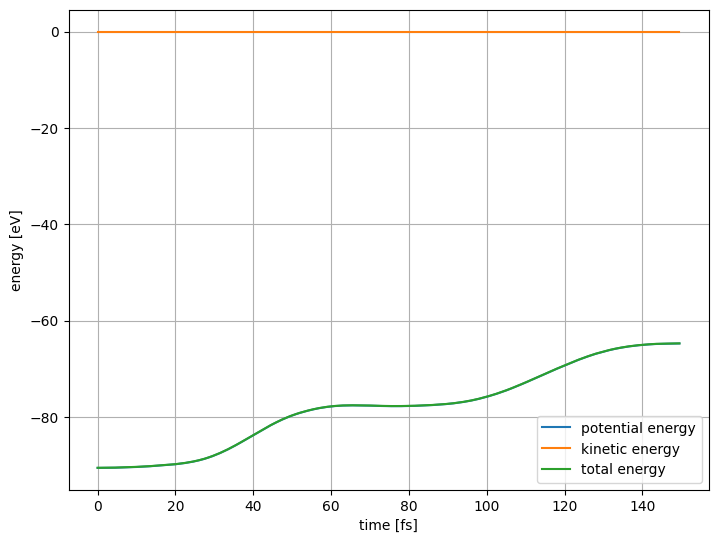

In [163]:
%matplotlib inline
plt.subplots_adjust(left=0, right=1, bottom=0, top=1)
plt.xlabel('time [fs]')
plt.ylabel('energy [eV]')
time = np.arange(num_steps) * timestep_fs
plt.plot(time, potential_energy, label='potential energy')
plt.plot(time, kinetic_energy, label='kinetic energy')
plt.plot(time, total_energy, label='total energy')
plt.legend()
plt.grid()

In [164]:
view_atoms(ase_atoms)